In [1]:
# 匯入套件
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import vectorbt as vbt
import seaborn as sns
from tqdm import tqdm

In [2]:
def daily_ic(g):
    x, y = g["pred"], g["ret_future"]
    m = x.notna() & y.notna()
    if m.sum() < 10:
        return np.nan
    return x[m].corr(y[m], method="spearman")

def ic_ir(ic_s, annualize=True, periods=252):
    s = ic_s.dropna()
    mu = s.mean()
    sd = s.std(ddof=1)
    ir = (mu / sd) if sd != 0 else np.nan
    if annualize:
        ir *= np.sqrt(periods)
    return {"IC_mean": mu, "IC_std": sd, "IR": ir, "N_days": len(s)}

def calculate_ic_ir(df_input, label='label', pred='pred'):
    # 計算每日 IC
    ic_series = df_input.groupby('date').apply(
        lambda x: x[pred].rank(pct=True).corr(x[label].rank(pct=True))
    )
    
    # 計算指標
    ic_mean = ic_series.mean()
    ic_std = ic_series.std()
    ir = ic_mean / ic_std if ic_std != 0 else 0
    
    return {
        "IC Mean": ic_mean,
        "IC Std": ic_std,
        "IR": ir,
        "IC > 0 Rate": (ic_series > 0).mean()
    }

In [3]:
FEES = 0.0035
def build_pf(price, pred, top_p, hold_p, reb,
             fees=FEES, freq="1D"):

    q_high = pred.quantile(1 - top_p, axis=1)   
    q_low  = pred.quantile(1 - hold_p, axis=1) 


    rebal_mask = np.zeros(len(pred), dtype=bool)
    rebal_mask[::reb] = True
    rebal_matrix = np.tile(rebal_mask[:, None], (1, pred.shape[1]))


    entries = (pred.apply(lambda x: x >= q_high, axis=0)) & rebal_matrix
    exits   = (pred.apply(lambda x: x <= q_low,  axis=0)) & rebal_matrix

    # Portfolio backtest
    pf = vbt.Portfolio.from_signals(
        close=price,
        entries=entries,
        exits=exits,
        fees=fees,
        cash_sharing=True,
        group_by=True,
        call_seq="auto",
        freq=freq,
        init_cash = 100_000_000
    )
    return pf

def run_vbt_backtest(df_input, top_p=0.05, hold_p=0.05, reb=5,
                     fees=FEES, freq="1D"):
    df = df_input.copy()
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(['ticker', 'date'])
    df['pred1'] = df.groupby('ticker')['pred'].shift(1)
    df = df.dropna(subset=['pred1']) # 移除第一天無法交易的空值
    price = df.pivot(index="date", columns="ticker", values="close").sort_index()
    pred  = df.pivot(index="date", columns="ticker", values="pred1").sort_index()

    # Align
    price, pred = price.align(pred, join="inner", axis=0)

    pf = build_pf(price, pred, top_p=top_p, hold_p=hold_p, reb=reb,
                  fees=fees, freq=freq)
    return pf


def run_comprehensive_grid(df_test, title,
                           top_pct_grid=(0.3,0.05,0.10),
                           hold_pct_grid=(0.30,0.50,0.70),
                           reb_grid=(1, 5, 10, 20),
                           fees=FEES, freq="1D",
                           plot_top_k=20):
    df = df_test.copy()
    df["date"] = pd.to_datetime(df["date"])

    df = df.sort_values(['ticker', 'date'])
    df['pred1'] = df.groupby('ticker')['pred'].shift(1)
    df = df.dropna(subset=['pred1'])
    price = df.pivot(index="date", columns="ticker", values="close").sort_index()
    pred  = df.pivot(index="date", columns="ticker", values="pred1").sort_index()

    # Align
    price, pred = price.align(pred, join="inner", axis=0)

    results = []
    print(f"正在分析 {title}...")

    for top_p in top_pct_grid:
        for hold_p in hold_pct_grid:
            for reb in reb_grid:
                pf = build_pf(price, pred, top_p=top_p, hold_p=hold_p, reb=reb,
                              fees=fees, freq=freq)

                # Sharpe (robust scalar)
                sr_obj = pf.sharpe_ratio()
                if isinstance(sr_obj, (pd.Series, pd.DataFrame, np.ndarray)):
                    # if it ever comes back vector-like, reduce to scalar
                    sr = float(np.asarray(sr_obj).ravel()[0])
                else:
                    sr = float(sr_obj)

                results.append({
                    "TOP_PCT": top_p,
                    "HOLD_PCT": hold_p,
                    "REBAL_EVERY": reb,
                    "Total Return": pf.total_return(),
                    "Sharpe": sr
                })

    res_df = pd.DataFrame(results).sort_values("Sharpe", ascending=False).reset_index(drop=True)

   
    k = min(plot_top_k, len(res_df))
    plt.figure(figsize=(12, 6))

    for i in range(k):
        row = res_df.iloc[i]
        top_p = float(row["TOP_PCT"])
        hold_p = float(row["HOLD_PCT"])
        reb = int(row["REBAL_EVERY"])
        total = float(row["Total Return"])

        pf = build_pf(price, pred, top_p=top_p, hold_p=hold_p, reb=reb,
                      fees=fees, freq=freq)

        label = (
        f"T{int(top_p*100)}%_H{int(hold_p*100)}%_R{reb} "
        f"(SR:{row['Sharpe']:.2f}, TR:{total:.2})"
      )
        plt.plot(pf.value(), label=label, alpha=0.7)

    plt.title(f"{title} - Top {k} Parameter Grid Search")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize="small")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return res_df

In [4]:
# 讀取資料
df = pd.read_pickle('data/processed_factors_data_log60.pkl')

In [5]:
N_DAYS = 5

df['ret_future'] = df.groupby('ticker')['close'].transform(
    lambda x: x.shift(-N_DAYS) / x - 1
)

df['label'] = df.groupby('date')['ret_future'].transform(
    lambda x: x.rank(pct=True)
)

In [6]:
# 定義特徵欄位 (Feature Selection)
exclude_cols = [
    'date','ticker',    # 索引資訊
    'close', # 原始價格 
    'ret_future', 'label',
    'price3' 
]

feature_cols = [c for c in df.columns if c not in exclude_cols]

print(f"使用的特徵數量: {len(feature_cols)}")
df = df.dropna(subset=feature_cols + ['label'])

使用的特徵數量: 342


In [7]:
TOP_K = 20         

all_dates = sorted(df["date"].unique())
n_dates = len(all_dates)

WINDOW_SIZE = int(n_dates * 0.5) 
STEP_SIZE = 63 

print(f"總天數: {n_dates}")
print(f"每個窗口總長度 (Window Size): {WINDOW_SIZE}")

baseline_valid_parts, baseline_test_parts = [], []
xgb_valid_parts, xgb_test_parts = [], []
cache = []

總天數: 2650
每個窗口總長度 (Window Size): 1325


In [8]:
TOP_K = 20
STEP_SIZE = 63                  
TRAIN_WINDOW = 252 * 3         
MIN_CS = 20                     
MIN_TRAIN_DAYS_FOR_IC = 80     

BACKTEST_START = pd.Timestamp("2020-01-01")
BACKTEST_END = None           


df = df.copy()
df["date"] = pd.to_datetime(df["date"])
all_dates = sorted(df["date"].unique())

if BACKTEST_END is None:
    BACKTEST_END = pd.Timestamp(all_dates[-1])


bt_dates = [d for d in all_dates if (d >= BACKTEST_START) and (d <= BACKTEST_END)]

baseline_test_parts = []
baseline_topk_by_window = []
window_tags = []
cache = []

print("Running rolling baseline...")

for i in tqdm(range(0, len(bt_dates), STEP_SIZE)):
    test_start = bt_dates[i]
    test_end = bt_dates[min(i + STEP_SIZE - 1, len(bt_dates) - 1)]
    test_dates = [d for d in bt_dates if (d >= test_start) and (d <= test_end)]


    idx = np.searchsorted(all_dates, test_start)
    train_start_idx = max(0, idx - TRAIN_WINDOW)
    train_dates = all_dates[train_start_idx:idx]

    if len(train_dates) < 60:   
        continue

    train_df = df[df["date"].isin(train_dates)].copy()
    test_df  = df[df["date"].isin(test_dates)].copy()

    if train_df.empty or test_df.empty:
        continue

    ic_list = []
    good_days = 0

    for d, g in train_df.groupby("date"):
        if g.shape[0] < MIN_CS:
            continue
        good_days += 1

        ic_day = g[feature_cols].rank(pct=True).corrwith(g["label"].rank(pct=True))
        ic_list.append(ic_day)

    if good_days < MIN_TRAIN_DAYS_FOR_IC or len(ic_list) == 0:
        continue

    ic_mean = pd.DataFrame(ic_list).mean().abs().sort_values(ascending=False)
    top_feats = ic_mean.head(TOP_K).index.tolist()

    t_base = test_df[["date", "ticker", "close", "ret_future", "label"]].copy()
    t_base["pred"] = test_df[top_feats].mean(axis=1)

    baseline_test_parts.append(t_base)
    baseline_topk_by_window.append(top_feats)
    window_tags.append(test_start)

    cache.append({
        "train_dates": train_dates,
        "test_dates": test_dates,
        "test_start": test_start,
        "test_end": test_end
    })

bt = pd.concat(baseline_test_parts, ignore_index=True)
bt["date"] = pd.to_datetime(bt["date"])

print("Baseline OOS start:", bt["date"].min())
print("Baseline OOS end  :", bt["date"].max())
print("Num OOS days      :", bt["date"].nunique())
print("Num windows kept  :", len(cache))

Running rolling baseline...


  0%|          | 0/23 [00:00<?, ?it/s]/Users/you-kaihsu/Desktop/Project/.conda/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning:

invalid value encountered in divide

/Users/you-kaihsu/Desktop/Project/.conda/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning:

invalid value encountered in divide

/Users/you-kaihsu/Desktop/Project/.conda/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning:

invalid value encountered in divide

/Users/you-kaihsu/Desktop/Project/.conda/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning:

invalid value encountered in divide

/Users/you-kaihsu/Desktop/Project/.conda/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning:

invalid value encountered in divide

/Users/you-kaihsu/Desktop/Project/.conda/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning:

invalid value encount

Baseline OOS start: 2020-01-02 00:00:00
Baseline OOS end  : 2025-11-17 00:00:00
Num OOS days      : 1427
Num windows kept  : 23


In [9]:
top_feats

['min5',
 'ep_ttm',
 'ep_ttm_rank',
 'min10',
 'kbar2',
 'qtld5',
 'qtld10',
 'IncomeFromContinuingOperations',
 'min20',
 'EquityAttributableToOwnersOfParent_y',
 'NetIncomeBeforeTax',
 'OperatingIncome',
 'EPS',
 'eps_ttm',
 'std5',
 'ma10',
 'ma5',
 'std10',
 'min30',
 'roc5']

In [10]:
def get_quarter_end_trading_dates(dates):
    """回傳每季最後一個交易日（存在於資料中的日期）"""
    d = pd.to_datetime(pd.Series(dates).dropna().unique())
    d = pd.Series(d).sort_values()
    q_end = d.groupby([d.dt.year, d.dt.quarter]).max().sort_values()
    return q_end.tolist()


def slice_by_quarter_vintage_rolling(df, vintage_date, train_years=3):
    """
    Rolling window:
    Train: [vintage - train_years, vintage]
    Test : 下一季（整季 OOS）
    """
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    vintage_date = pd.to_datetime(vintage_date)

    train_start = vintage_date - pd.DateOffset(years=train_years)
    train_df = df[(df["date"] >= train_start) & (df["date"] <= vintage_date)].copy()

    next_q = (vintage_date.to_period("Q") + 1)
    test_df = df[df["q"] == next_q].copy()
    return train_df, test_df


def model_builder_reg_simple_stable():
    # 簡單、偏保守，目標是穩定排序而非極致擬合
    return xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=20,
        reg_lambda=20.0,
        random_state=42,
        n_jobs=-1,
        tree_method="hist",
        max_bin=256
    )


def run_quarterly_vintage_models_reg(
    df,
    feature_cols,
    model_builder=model_builder_reg_simple_stable,
    train_years=3,
    start_year=2019,
    end_year=2025,
):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["date", "ticker"]).copy()

    # 季度欄位
    df["q"] = df["date"].dt.to_period("Q")

    # vintages
    dates = df["date"].drop_duplicates().sort_values().to_list()
    vintages = get_quarter_end_trading_dates(dates)

    if start_year is not None:
        vintages = [d for d in vintages if pd.to_datetime(d).year >= start_year]
    if end_year is not None:
        vintages = [d for d in vintages if pd.to_datetime(d).year <= end_year]

    all_oos = []
    models = []

    for vd in tqdm(vintages, desc="Quarterly vintages (Reg)"):
        train_df, test_df = slice_by_quarter_vintage_rolling(df, vd, train_years=train_years)
        if len(train_df) == 0 or len(test_df) == 0:
            continue

        train_df = train_df.sort_values(["date", "ticker"])
        test_df  = test_df.sort_values(["date", "ticker"])

        # 轉成乾淨的數值矩陣（避免 dtype 問題）
        X_train = train_df[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).to_numpy()
        y_train = pd.to_numeric(train_df["label"], errors="coerce").fillna(0.0).to_numpy()
        X_test  = test_df[feature_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0).to_numpy()

        model = model_builder()
        model.fit(X_train, y_train)

        test_df["pred"] = model.predict(X_test)

        models.append({"vintage_date": pd.to_datetime(vd), "model": model})
        all_oos.append(test_df[["date", "ticker", "pred", "label", "close"]])

    if len(all_oos) == 0:
        return pd.DataFrame(columns=["date", "ticker", "pred", "label", "close"]), models

    oos_pred_df = pd.concat(all_oos, ignore_index=True).sort_values(["date", "ticker"])
    return oos_pred_df, models

In [11]:
oos_pred_df, models = run_quarterly_vintage_models_reg(
    df=df,
    feature_cols=feature_cols,
    train_years=3,
    start_year=2019,
    end_year=2025
)
print(oos_pred_df.head())
print("num models:", len(models))
print("oos range:", oos_pred_df["date"].min(), "->", oos_pred_df["date"].max())

Quarterly vintages (Reg): 100%|██████████| 28/28 [42:57<00:00, 92.04s/it] 


        date   ticker      pred     label      close
0 2019-04-01  1101.TW  0.560938  0.607296  24.380905
1 2019-04-01  1102.TW  0.537887  0.655579  26.207874
2 2019-04-01  1103.TW  0.462268  0.536481  10.867743
3 2019-04-01  1104.TW  0.570507  0.332618  13.046306
4 2019-04-01  1108.TW  0.490546  0.052575   5.573911
num models: 27
oos range: 2019-04-01 00:00:00 -> 2025-11-17 00:00:00


In [12]:
oos_pred_df["date"] = pd.to_datetime(oos_pred_df["date"])
print(oos_pred_df["date"].min(), oos_pred_df["date"].max())

2019-04-01 00:00:00 2025-11-17 00:00:00


In [13]:
START = pd.Timestamp("2020-01-01")
END   = pd.Timestamp("2025-11-17")

oos_bt = oos_pred_df.copy()
oos_bt["date"] = pd.to_datetime(oos_bt["date"])
oos_bt = oos_bt[(oos_bt["date"] >= START) & (oos_bt["date"] <= END)].copy()

print(oos_bt["date"].min(), oos_bt["date"].max())

2020-01-02 00:00:00 2025-11-17 00:00:00


In [14]:
t_xgb = oos_bt.copy()
t_xgb["date"] = pd.to_datetime(t_xgb["date"])
t_xgb = t_xgb.sort_values(["ticker", "date"])

In [40]:
pf_b_test = run_vbt_backtest(bt, top_p=0.005, hold_p=0.00001, reb=5)
print(pf_b_test.stats())
pf_b_test.plot().show()

Start                               2020-01-03 00:00:00
End                                 2025-11-17 00:00:00
Period                               1426 days 00:00:00
Start Value                                 100000000.0
End Value                               18274626.121391
Total Return [%]                             -81.725374
Benchmark Return [%]                          127.25867
Max Gross Exposure [%]                            100.0
Total Fees Paid                        161929708.832764
Max Drawdown [%]                              95.543931
Max Drawdown Duration                1055 days 00:00:00
Total Trades                                        194
Total Closed Trades                                 193
Total Open Trades                                     1
Open Trade PnL                          -1554903.249377
Win Rate [%]                                  43.523316
Best Trade [%]                                98.497051
Worst Trade [%]                              -52

/Users/you-kaihsu/Desktop/Project/.conda/lib/python3.11/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

/Users/you-kaihsu/Desktop/Project/.conda/lib/python3.11/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



In [49]:
pf_x_test = run_vbt_backtest(t_xgb, top_p=0.001, hold_p=0.00001, reb=5)
print(pf_x_test.stats())
pf_x_test.plot().show()

Start                               2020-01-03 00:00:00
End                                 2025-11-17 00:00:00
Period                               1426 days 00:00:00
Start Value                                 100000000.0
End Value                              297178067.181659
Total Return [%]                             197.178067
Benchmark Return [%]                          127.25867
Max Gross Exposure [%]                            100.0
Total Fees Paid                        328672971.266268
Max Drawdown [%]                              78.598124
Max Drawdown Duration                 765 days 00:00:00
Total Trades                                        268
Total Closed Trades                                 267
Total Open Trades                                     1
Open Trade PnL                          -1040123.235136
Win Rate [%]                                  40.449438
Best Trade [%]                               228.356584
Worst Trade [%]                              -26

/Users/you-kaihsu/Desktop/Project/.conda/lib/python3.11/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning:

Subplot 'orders' does not support grouped data

/Users/you-kaihsu/Desktop/Project/.conda/lib/python3.11/site-packages/vectorbt/generic/plots_builder.py:339: UserWarning:

Subplot 'trade_pnl' does not support grouped data



回頭檢查log
有可能買進、賣出 or 保留

In [50]:
# 比較兩者（測試集）
metrics_b = calculate_ic_ir(bt)
metrics_x = calculate_ic_ir(t_xgb)

summary_icir = pd.DataFrame({"Baseline": metrics_b, "XGBoost": metrics_x})
print("\n因子預測能力比較 (IC/IR)")
print(summary_icir.round(4))

/var/folders/gk/tqz928vx1m96n53nylzj1y800000gn/T/ipykernel_47835/596541454.py:19: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.




因子預測能力比較 (IC/IR)
             Baseline  XGBoost
IC Mean        0.0557   0.0991
IC Std         0.1152   0.1174
IR             0.4833   0.8438
IC > 0 Rate    0.7092   0.8059


/var/folders/gk/tqz928vx1m96n53nylzj1y800000gn/T/ipykernel_47835/596541454.py:19: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



/var/folders/gk/tqz928vx1m96n53nylzj1y800000gn/T/ipykernel_47835/1970876131.py:2: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

/var/folders/gk/tqz928vx1m96n53nylzj1y800000gn/T/ipykernel_47835/1970876131.py:3: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



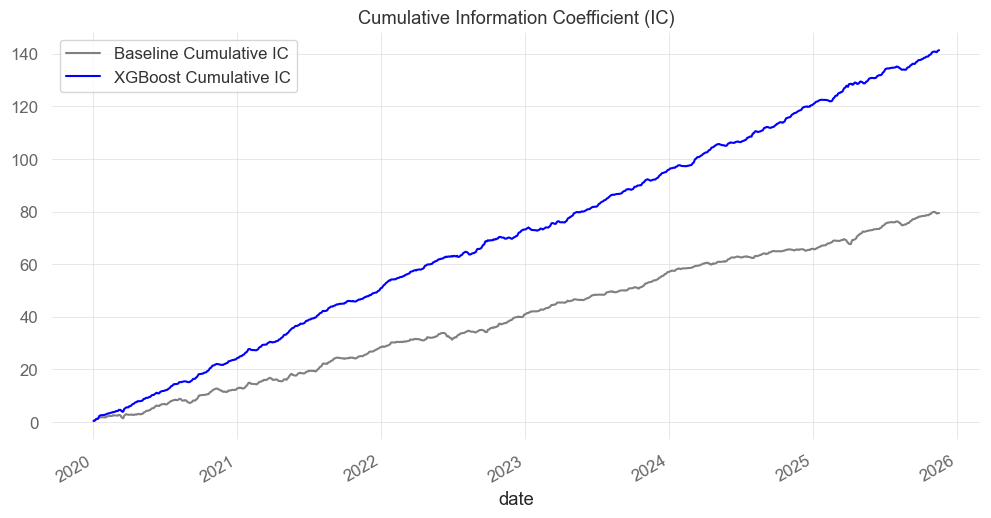

In [51]:
# 繪製累積 IC 圖表
ic_series_x = t_xgb.groupby('date').apply(lambda x: x['pred'].rank(pct=True).corr(x['label'].rank(pct=True)))
ic_series_b = bt.groupby('date').apply(lambda x: x['pred'].rank(pct=True).corr(x['label'].rank(pct=True)))

plt.figure(figsize=(12, 6))
ic_series_b.cumsum().plot(label='Baseline Cumulative IC', color='gray')
ic_series_x.cumsum().plot(label='XGBoost Cumulative IC', color='blue')
plt.title("Cumulative Information Coefficient (IC)")
plt.legend()
plt.show()

正在分析 Baseline (Rank IC Weighted)...


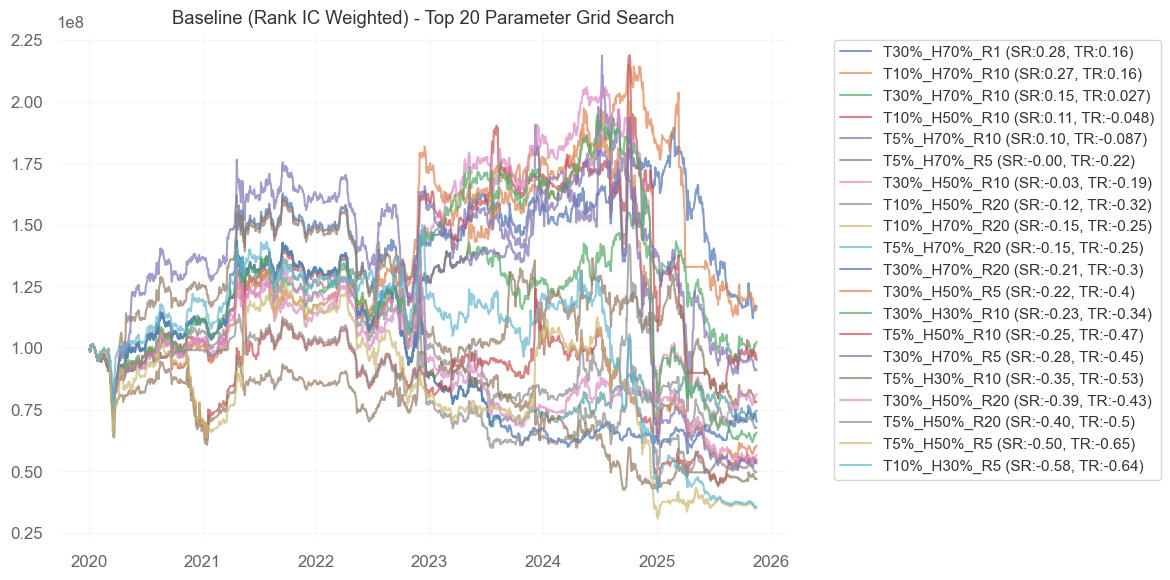

正在分析 XGBoost Machine Learning...


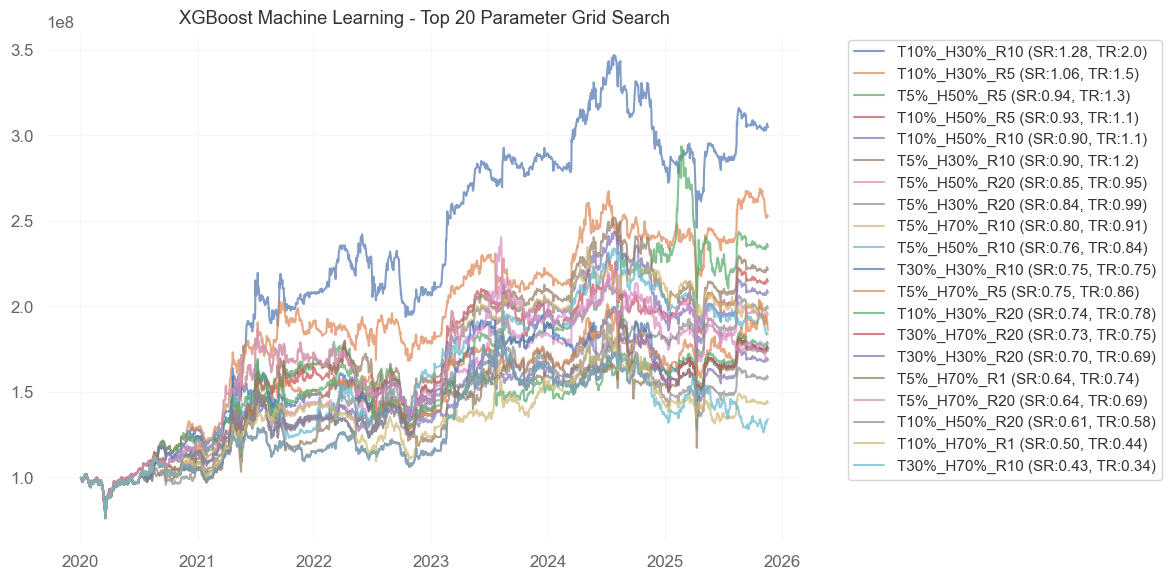

In [52]:
baseline_grid_res = run_comprehensive_grid(bt, "Baseline (Rank IC Weighted)")
xgboost_grid_res  = run_comprehensive_grid(t_xgb, "XGBoost Machine Learning")

In [20]:
pf_ret = pf_x_test.returns()

bench_ret = pf_x_test.benchmark_returns()

pf_ret, bench_ret = pf_ret.align(bench_ret, join="inner")
print(pf_ret.index.min(), pf_ret.index.max())
print(bench_ret.index.min(), bench_ret.index.max())

2020-01-03 00:00:00 2025-11-17 00:00:00
2020-01-03 00:00:00 2025-11-17 00:00:00


In [21]:
excess = (pf_ret - bench_ret)

win = 60  # 60 個交易日
excess_roll = excess.rolling(win).mean()

regime = pd.Series(index=excess_roll.index, dtype="object")
regime[excess_roll > 0] = "Outperform"
regime[excess_roll <= 0] = "Underperform"
regime = regime.dropna()
print(regime.value_counts())

Underperform    809
Outperform      558
Name: count, dtype: int64


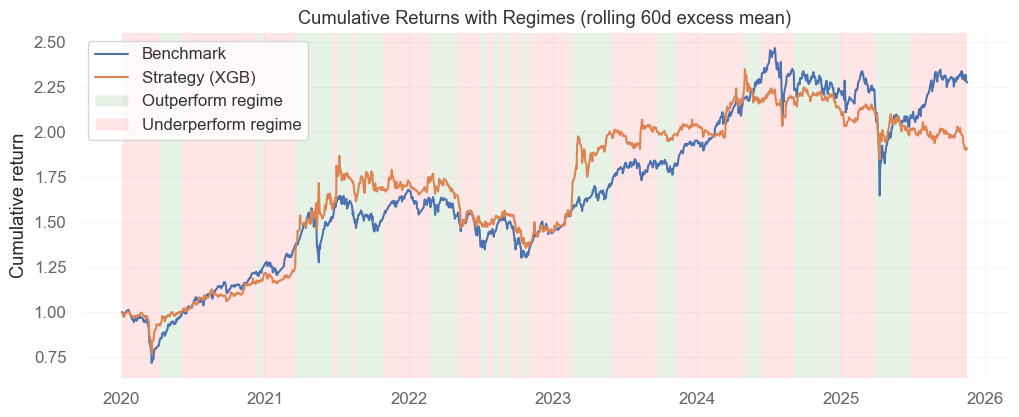

In [22]:
pf_cum = (1 + pf_ret).cumprod()
bm_cum = (1 + bench_ret).cumprod()

regime = pd.Series(np.where(excess_roll > 0, 1, 0), index=excess_roll.index)
regime = regime.dropna()  # rolling 前 win-1 天會被丟掉

fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(bm_cum.index, bm_cum.values, label="Benchmark")
ax.plot(pf_cum.index, pf_cum.values, label="Strategy (XGB)")

idx = regime.index
state = regime.values

color_out = "green"   # Outperform
color_under = "red"   # Underperform
alpha = 0.10

start = idx[0]
cur = state[0]

for i in range(1, len(idx)):
    if state[i] != cur:
        end = idx[i]
        ax.axvspan(start, end, alpha=alpha,
                   color=(color_out if cur == 1 else color_under),
                   linewidth=0)
        start = end
        cur = state[i]

ax.axvspan(start, idx[-1], alpha=alpha,
           color=(color_out if cur == 1 else color_under),
           linewidth=0)

from matplotlib.patches import Patch
ax.legend(handles=[
    ax.lines[0], ax.lines[1],
    Patch(facecolor=color_out, alpha=alpha, label="Outperform regime"),
    Patch(facecolor=color_under, alpha=alpha, label="Underperform regime"),
])

ax.set_title(f"Cumulative Returns with Regimes (rolling {win}d excess mean)")
ax.set_ylabel("Cumulative return")
ax.grid(True, alpha=0.3)
plt.show()

In [23]:
regime_daily = pd.Series(np.where(excess_roll > 0, "Outperform", "Underperform"),
                         index=excess_roll.index).dropna()

# 每個季度用多數決決定 regime
regime_q = regime_daily.groupby(regime_daily.index.to_period("Q")).agg(lambda s: s.value_counts().idxmax())
regime_q.name = "regime"

In [24]:
def get_gain_importance(xgb_model, feature_cols):
    booster = xgb_model.get_booster()
    score = booster.get_score(importance_type="gain")  

    imp = pd.Series(0.0, index=feature_cols)
    for i, col in enumerate(feature_cols):
        imp[col] = score.get(f"f{i}", 0.0)
    return imp

rows = []
for m in models:
    vd = pd.to_datetime(m["vintage_date"])
    oos_q = vd.to_period("Q") + 1  # 下一季 OOS

    imp = get_gain_importance(m["model"], feature_cols)
    imp = imp / (imp.sum() + 1e-12)  # normalize

    rows.append({
        "vintage_date": vd,
        "oos_quarter": oos_q,
        **imp.to_dict()
    })

imp_df = pd.DataFrame(rows)

# 合併季度 regime 標籤
imp_df = imp_df.merge(regime_q.reset_index().rename(columns={"date":"oos_quarter"}),
                      on="oos_quarter", how="left")

In [25]:
imp_2025 = imp_df[imp_df["oos_quarter"].astype(str).str.startswith("2025")].copy()

K = 30
top_by_q = {}
for q, g in imp_2025.groupby("oos_quarter"):
    s = g[feature_cols].mean().sort_values(ascending=False)
    top_by_q[str(q)] = s.head(K)

top_by_q_df = pd.DataFrame(top_by_q).T  # rows=quarter, cols=factors
top_by_q_df = top_by_q_df.fillna(0.0)

with pd.option_context(
    "display.max_rows", None,
    "display.max_columns", None,
    "display.width", 0,
    "display.max_colwidth", None
):
    display(top_by_q_df.fillna(0.0))

AccountsPayable_x  CashFlowsFromOperatingActivities  \
2025Q1           0.000000                          0.000000   
2025Q2           0.006491                          0.005529   
2025Q3           0.005737                          0.000000   
2025Q4           0.005404                          0.000000   

        CurrentLiabilities       EPS  \
2025Q1            0.000000  0.000000   
2025Q2            0.000000  0.000000   
2025Q3            0.000000  0.009418   
2025Q4            0.005656  0.005965   

        EquivalentIssueSharesOfAdvanceReceiptsForOrdinaryShare      IC_C  \
2025Q1                                                0.006125  0.000000   
2025Q2                                                0.005567  0.000000   
2025Q3                                                0.000000  0.005145   
2025Q4                                                0.000000  0.000000   

        NetIncomeBeforeTax  NoncurrentAssets_per  OperatingIncome  \
2025Q1            0.000000              0.006063         0.011978   
2025Q2            0.000000              0.006459         0.012394   
2025Q3            0.000000              0.005315         0.013432   
2025Q4            0.006289              0.000000         0.026022   

        OrdinaryShare_per  PropertyPlantAndEquipment_per  RetainedEarnings  \
2025Q1           0.006655                       0.005705          0.000000   
2025Q2           0.005529                       0.000000          0.000000   
2025Q3           0.000000                       0.000000          0.000000   
2025Q4           0.000000                       0.000000          0.006255   

        alpha_016  alpha_038  alpha_040  alpha_047  asset_turnover  \
2025Q1   0.000000   0.005374   0.009291   0.007061        0.000000   
2025Q2   0.000000   0.000000   0.009614   0.005177        0.000000   
2025Q3   0.000000   0.000000   0.006820   0.005038        0.000000   
2025Q4   0.006394   0.000000   0.007828   0.000000        0.005214   

        asset_turnover_rank     beta5    cntd60    cntn60    cntp60    cord10  \
2025Q1             0.000000  0.000000  0.000000  0.008057  0.005567  0.000000   
2025Q2             0.000000  0.000000  0.005408  0.006696  0.000000  0.000000   
2025Q3             0.005809  0.004999  0.005534  0.006685  0.000000  0.006379   
2025Q4             0.000000  0.005209  0.005144  0.005806  0.006633  0.000000   

          cord20    cord30    cord60    ep_ttm  ep_ttm_rank   eps_ttm  \
2025Q1  0.006748  0.006352  0.005331  0.018373     0.013774  0.000000   
2025Q2  0.008328  0.000000  0.000000  0.018204     0.011897  0.005291   
2025Q3  0.006472  0.000000  0.006535  0.022169     0.018633  0.000000   
2025Q4  0.005178  0.006041  0.005990  0.015783     0.020937  0.018828   

          imin30    imin60     kbar2     kbar6     kbar8      ma10      ma30  \
2025Q1  0.007012  0.000000  0.014835  0.007140  0.007902  0.000000  0.005669   
2025Q2  0.000000  0.005248  0.018034  0.007348  0.006957  0.006463  0.006707   
2025Q3  0.000000  0.000000  0.005981  0.007001  0.007488  0.005125  0.005121   
2025Q4  0.000000  0.000000  0.007042  0.007811  0.008129  0.008953  0.000000   

             ma5     max10    max20      max5     max60     min10     min20  \
2025Q1  0.006196  0.005661  0.00713  0.000000  0.007007  0.008310  0.000000   
2025Q2  0.000000  0.000000  0.00000  0.006794  0.000000  0.011036  0.006614   
2025Q3  0.005787  0.000000  0.00000  0.000000  0.000000  0.012722  0.000000   
2025Q4  0.005744  0.000000  0.00000  0.000000  0.000000  0.006480  0.000000   

            min5    price2    qtld10     qtld5     rsq30     std10    std20  \
2025Q1  0.037909  0.000000  0.000000  0.010007  0.000000  0.000000  0.00622   
2025Q2  0.034107  0.005241  0.008010  0.007538  0.005415  0.000000  0.00000   
2025Q3  0.028216  0.000000  0.039594  0.017179  0.000000  0.005233  0.00000   
2025Q4  0.032439  0.000000  0.000000  0.016639  0.000000  0.005441  0.00000   

          sumd30    sumn20  vp_corr10     vstd5    vstd60

In [26]:
def top_factors_each_quarter(df_imp, top_n=10):
    out = []
    for q, row in df_imp.iterrows():
        s = row[row > 0].sort_values(ascending=False).head(top_n)
        tmp = s.reset_index()
        tmp.columns = ["factor", "importance"]
        tmp["quarter"] = q
        out.append(tmp)
    return pd.concat(out, ignore_index=True)

top10_each_q = top_factors_each_quarter(top_by_q_df, top_n=10)
print(top10_each_q)

             factor  importance quarter
0              min5    0.037909  2025Q1
1            ep_ttm    0.018373  2025Q1
2             kbar2    0.014835  2025Q1
3       ep_ttm_rank    0.013774  2025Q1
4   OperatingIncome    0.011978  2025Q1
5             qtld5    0.010007  2025Q1
6         alpha_040    0.009291  2025Q1
7             min10    0.008310  2025Q1
8            cntn60    0.008057  2025Q1
9             kbar8    0.007902  2025Q1
10             min5    0.034107  2025Q2
11           ep_ttm    0.018204  2025Q2
12            kbar2    0.018034  2025Q2
13  OperatingIncome    0.012394  2025Q2
14      ep_ttm_rank    0.011897  2025Q2
15            min10    0.011036  2025Q2
16        alpha_040    0.009614  2025Q2
17        vp_corr10    0.009351  2025Q2
18           cord20    0.008328  2025Q2
19           qtld10    0.008010  2025Q2
20           qtld10    0.039594  2025Q3
21             min5    0.028216  2025Q3
22           ep_ttm    0.022169  2025Q3
23      ep_ttm_rank    0.018633  2025Q3


In [27]:
imp_2023 = imp_df[imp_df["oos_quarter"].astype(str).str.startswith("2023")].copy()

K = 30
top_by_q = {}
for q, g in imp_2023.groupby("oos_quarter"):
    s = g[feature_cols].mean().sort_values(ascending=False)
    top_by_q[str(q)] = s.head(K)

top_by_q_df = pd.DataFrame(top_by_q).T  # rows=quarter, cols=factors
top_by_q_df = top_by_q_df.fillna(0.0)

with pd.option_context(
    "display.max_rows", None,
    "display.max_columns", None,
    "display.width", 0,
    "display.max_colwidth", None
):
    display(top_by_q_df.fillna(0.0))

CapitalSurplus  CashReceivedThroughOperations  \
2023Q1        0.005539                       0.000000   
2023Q2        0.000000                       0.005615   
2023Q3        0.000000                       0.000000   
2023Q4        0.000000                       0.000000   

        EquityAttributableToOwnersOfParent_per  \
2023Q1                                0.005861   
2023Q2                                0.000000   
2023Q3                                0.000000   
2023Q4                                0.000000   

        EquityAttributableToOwnersOfParent_x  GrossProfit  Inventories  \
2023Q1                              0.005724     0.005785      0.00000   
2023Q2                              0.000000     0.005275      0.00000   
2023Q3                              0.000000     0.000000      0.00655   
2023Q4                              0.000000     0.000000      0.00000   

        NoncontrollingInterests  OperatingIncome  RetainedEarnings  \
2023Q1                 0.000000         0.006716          0.000000   
2023Q2                 0.005546         0.007100          0.000000   
2023Q3                 0.000000         0.008017          0.000000   
2023Q4                 0.000000         0.009047          0.006122   

        RetainedEarnings_per   Revenue  alpha_005  alpha_008  alpha_011  \
2023Q1              0.000000  0.000000   0.006576   0.000000   0.007259   
2023Q2              0.000000  0.000000   0.000000   0.005308   0.005513   
2023Q3              0.000000  0.015889   0.000000   0.000000   0.006592   
2023Q4              0.005832  0.005570   0.000000   0.000000   0.000000   

        alpha_012  alpha_013  alpha_018  alpha_024  alpha_033  alpha_040  \
2023Q1   0.009275   0.012675   0.009462   0.006195    0.00000   0.018190   
2023Q2   0.009664   0.015851   0.008496   0.000000    0.00000   0.013897   
2023Q3   0.010096   0.008397   0.012799   0.006723    0.00685   0.014243   
2023Q4   0.006732   0.007579   0.008981   0.000000    0.00000   0.012899   

        alpha_046  alpha_049     beta5    cntd60    cntn10    cntn60  \
2023Q1    0.00000   0.000000  0.000000  0.000000  0.000000  0.006111   
2023Q2    0.00947   0.000000  0.000000  0.005677  0.000000  0.000000   
2023Q3    0.00000   0.005718  0.005498  0.000000  0.005321  0.006106   
2023Q4    0.00000   0.000000  0.000000  0.000000  0.000000  0.006415   

          cord30  current_ratio    ep_ttm  ep_ttm_rank    imin20    imin30  \
2023Q1  0.000000       0.000000  0.011973     0.007417  0.000000  0.005458   
2023Q2  0.000000       0.000000  0.008904     0.009979  0.000000  0.000000   
2023Q3  0.000000       0.000000  0.015198     0.009273  0.006561  0.000000   
2023Q4  0.005352       0.005333  0.012365     0.012704  0.000000  0.000000   

          imxd10     kbar2     kbar6     kbar8      ma10      ma30       ma5  \
2023Q1  0.000000  0.008023  0.008476  0.015309  0.000000  0.009638  0.000000   
2023Q2  0.005377  0.010489  0.007710  0.014443  0.000000  0.006547  0.012355   
2023Q3  0.000000  0.008896  0.006679  0.013041  0.000000  0.005982  0.009348   
2023Q4  0.000000  0.005718  0.007318  0.015479  0.005435  0.005683  0.006403   

           max10     max20      max5      min5     qtld5    qtld60    qtlu30  \
2023Q1  0.000000  0.005461  0.000000  0.020865  0.009760  0.005681  0.005772   
2023Q2  0.000000  0.005949  0.000000  0.019740  0.015062  0.000000  0.007468   
2023Q3  0.014924  0.006549  0.000000  0.028881  0.009585  0.000000  0.006044   
2023Q4  0.010401  0.006801  0.010979  0.030860  0.009654  0.000000  0.006105   

           roc30     std10      std5    sumn30    sump20     vma20     vma30  \
2023Q1  0.006615  0.000000  0.000000  0.006229  0.005972  0.000000  0.007612   
2023Q2  0.005777  0.000000  0.008773  0.005473  0.005313  0.000000  0.007753   
2023Q3  0.000000  0.000000  0.000000  0.005446  0.000000  0.005961  0.006732   
2023Q4  0.000000  0.007789  0.000000  0.005705  0.005853  0.007278  0.000000   

          vstd30  
2023Q1  0.012230  

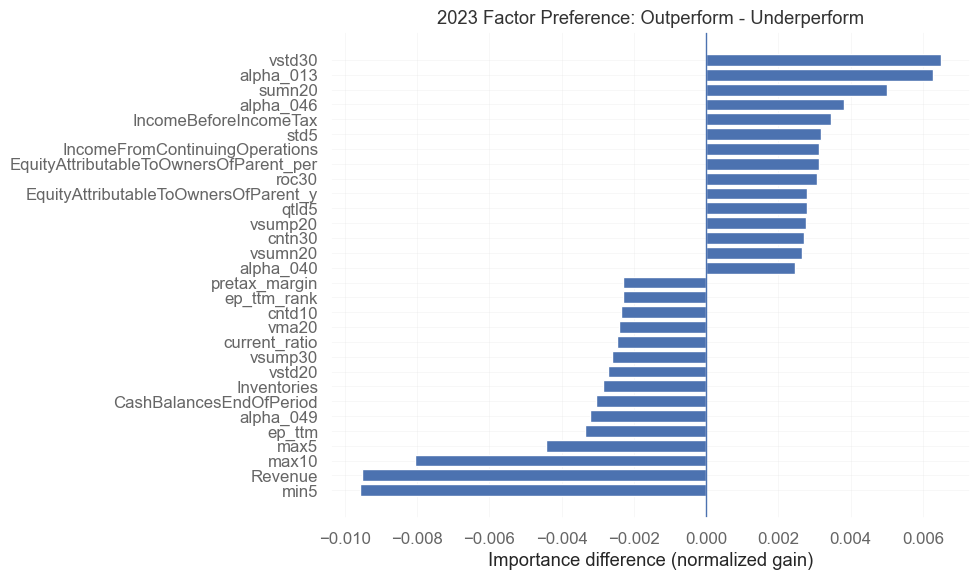

In [28]:
imp_2023 = imp_df[imp_df["oos_quarter"].astype(str).str.startswith("2023")].copy()

out_2023 = imp_2023[imp_2023["regime"] == "Outperform"]
under_2023 = imp_2023[imp_2023["regime"] == "Underperform"]

mean_out = out_2023[feature_cols].mean()
mean_under = under_2023[feature_cols].mean()

diff = (mean_out - mean_under).sort_values(ascending=False)

K = 15
plot_s = pd.concat([diff.head(K), diff.tail(K)]).sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(plot_s.index, plot_s.values)
ax.axvline(0, linewidth=1)
ax.set_title("2023 Factor Preference: Outperform - Underperform")
ax.set_xlabel("Importance difference (normalized gain)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

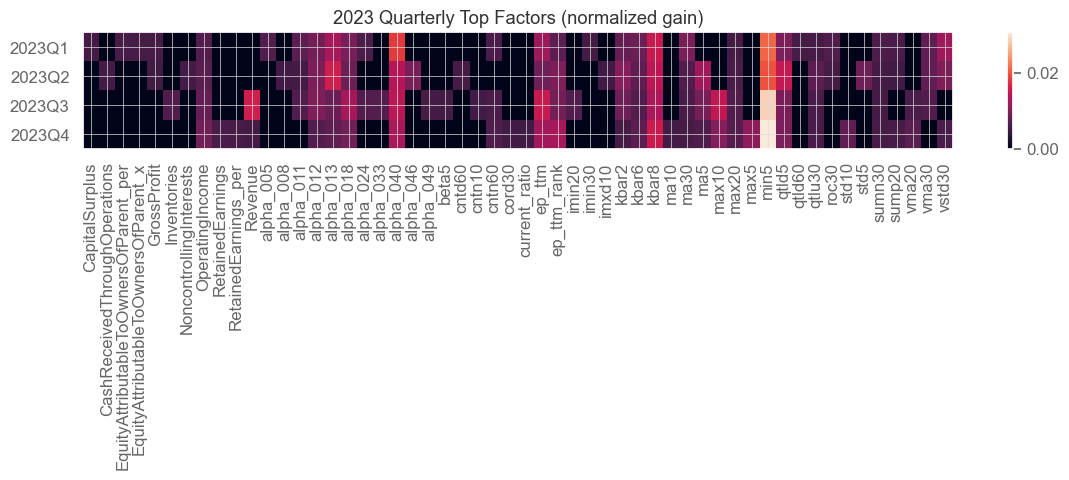

In [29]:
heat = top_by_q_df.fillna(0.0)

fig, ax = plt.subplots(figsize=(12, 5))
im = ax.imshow(heat.values, aspect="auto")
ax.set_yticks(range(len(heat.index)))
ax.set_yticklabels(heat.index)
ax.set_xticks(range(len(heat.columns)))
ax.set_xticklabels(heat.columns, rotation=90)

ax.set_title("2023 Quarterly Top Factors (normalized gain)")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

                 mean_excess  sharpe_excess  hit_rate    n
disp_regime                                               
High Dispersion     0.000230       0.239202  0.437135  684
Low Dispersion     -0.000442      -0.653388  0.425876  742


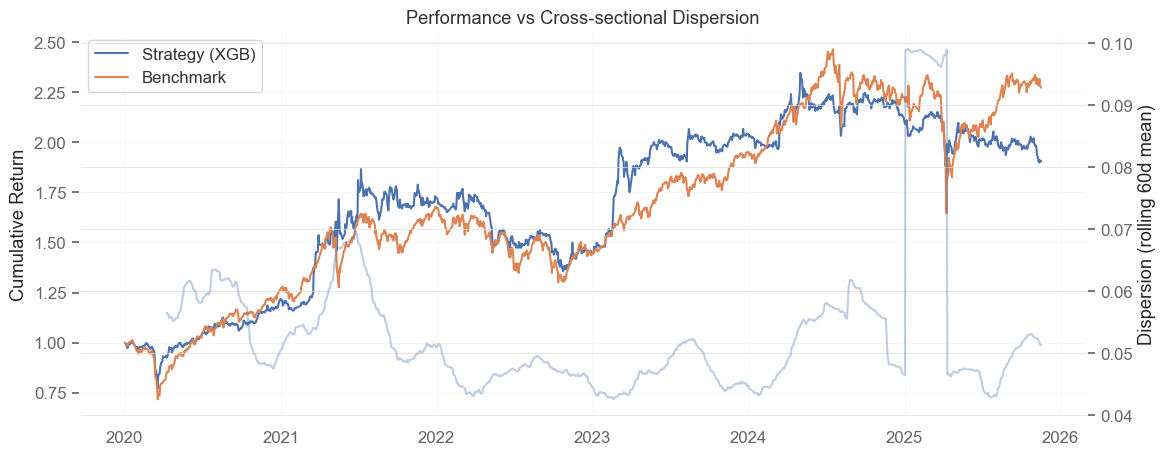

In [30]:
disp = (
    df.groupby("date")["ret_future"]
      .std()
      .rename("disp")
)

pf_ret = pf_x_test.returns()
bench_ret = pf_x_test.benchmark_returns()


tmp = pd.concat([pf_ret.rename("pf"), bench_ret.rename("bm"), disp], axis=1).dropna()
tmp["excess"] = tmp["pf"] - tmp["bm"]


win = 60
tmp["disp_roll"] = tmp["disp"].rolling(win).mean()

cut = tmp["disp_roll"].median()
tmp["disp_regime"] = np.where(tmp["disp_roll"] >= cut, "High Dispersion", "Low Dispersion")


summary = tmp.groupby("disp_regime").agg(
    mean_excess=("excess", "mean"),
    sharpe_excess=("excess", lambda x: (x.mean() / x.std()) * np.sqrt(252) if x.std() != 0 else np.nan),
    hit_rate=("excess", lambda x: (x > 0).mean()),
    n=("excess", "size")
)
print(summary)


pf_cum = (1 + tmp["pf"]).cumprod()
bm_cum = (1 + tmp["bm"]).cumprod()

fig, ax1 = plt.subplots(figsize=(13,5))
ax1.plot(pf_cum.index, pf_cum.values, label="Strategy (XGB)")
ax1.plot(bm_cum.index, bm_cum.values, label="Benchmark")
ax1.set_ylabel("Cumulative Return")
ax1.legend(loc="upper left")
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(tmp.index, tmp["disp_roll"], alpha=0.35)
ax2.set_ylabel(f"Dispersion (rolling {win}d mean)")

plt.title("Performance vs Cross-sectional Dispersion")
plt.show()